## Bike Sharing Demand - Machine Learning 편 ver.1
앞서 EDA를 통해 데이터가 어떻게 구성되어 있고, 변수 간의 관계를 시각화하여 파악하였다.  
이제 데이터를 조금 가공하여 머신러닝을 적용해 count를 예측하자.   

---
<앞에서 봤던 것들 정리>   
1. 연속형 변수: 온도(temp, atemp), 습도(humidity), 풍속(windspeed) 
    - 각각 대여량과 정비례, 반비례, 정비례했고 특히 `hour`별로 봤을 때 대여량과 상관성을 가짐
        - 특히 `casual일 때!`
2. 카테고리 변수: 분기(season), 날씨(weather), 평일(workingday), 공휴일(holiday)
    - 각각 늦봄~초가을(2,3사분기) / 날씨 화창(1일 때) 대여량이 많았다.
    - 평일과 공휴일은 `hour`별로 보면 뚜렷한 차이를 보임 
        - 특히 `casual`일 때
3. 대여량의 대부분은 예약(registered). 그래서 예약건이 8, 즉석이용(casual)이 2 였음
4. casual일 때와 registered일 때의 데이터 양상이 달라지는 것으로 보아 두 개를 따로 분리하여 2개의 모델을 만들고, 최종 제출은 casual + registered를 한 count를 제출.

## 1.Load the data
- EDA 편에서 확인한 결과 중복이나 결측치는 없었다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#train data : target은 count 컬럼 
train = pd.read_csv('data/train.csv', parse_dates=['datetime'])
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# test data
test = pd.read_csv('data/test.csv', parse_dates=['datetime'])
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 2. Preprocessing
#### 1) train data에서 필요한 열을 생성하자.

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek

#불필요한 열 삭제
del train['datetime']

train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5


#### 2) weather ==4 아웃라이어 제거(1개 제거됨)

In [45]:
print('제거 전 ', len(train))
train = train.loc[train['weather'] !=4 ]
print('제거 후: ', len(train))

제거 전  10738
제거 후:  10738


#### 3) count 열의 아웃라이어 제거
- 3시그마를 초과하는 경우 제거

In [6]:
train = train[train['count'] - train['count'].mean() < 3*train['count'].std()]
train.reset_index(inplace =True, drop = True)
print(train.shape)
display(train.head())

(10738, 15)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


#### 4) casual과 registered를 따로 데이터셋을 생성할 것임. 두개 각각에 대해 로그변환

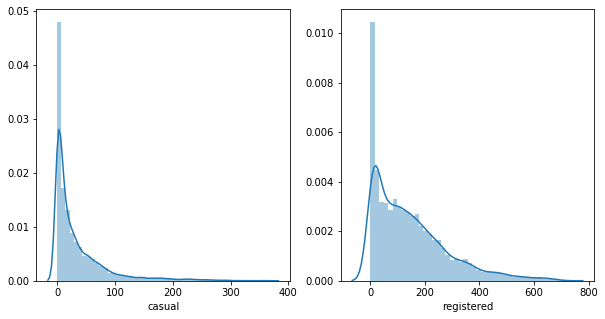

In [7]:
# casual & registered 의 분포 파악
figure, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.distplot(train['casual'], ax = ax1)
sns.distplot(train['registered'], ax = ax2)

위의 그래프 모두 왼쪽으로 치우쳐져 있으므로, **로그변환**을 통해 target의 분포를 맞추자.

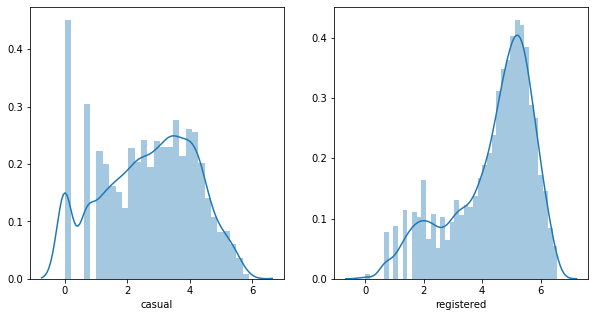

In [8]:
# 로그변환 후 
figure, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.distplot(np.log1p(train['casual']), ax = ax1)
sns.distplot(np.log1p(train['registered']), ax = ax2)

완벽한 정규분포 형태는 아니지만, 좀 더 정규분포에 가까워졌으므로 이를 사용하기로 한다!

In [9]:
train['casual'] = np.log1p(train['casual'])
train['registered'] = np.log1p(train['registered'])

display(train.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,1.386294,2.639057,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2.197225,3.496508,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,1.791759,3.332205,32,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,1.386294,2.397895,13,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0.000000,0.693147,1,2011,1,4,5


In [10]:
# skew(왜도) 확인 : +- 2 범위 안에 들어가므로 치우침이 없다고 볼 수 있음
print(train['casual'].skew())
print(train['registered'].skew())

-0.20868137442089577
-0.8833359947904165


#### 5) 카테고리 변수 ~더미변수화~ -> 그냥 카테고리로!!
- 처음에 더미로 만들었다가 성능이 많이 떨어져 category로 type을 변경하는 방법을 사용함

In [11]:
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,1.386294,2.639057,16,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2.197225,3.496508,40,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,1.791759,3.332205,32,2011,1,2,5


In [12]:
cate_name = ['weather', 'season', 'year', 'month', 'hour', 'dayofweek']

for c in cate_name:
    train[c] = train[c].astype('category')
train.dtypes

season        category
holiday          int64
workingday       int64
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual         float64
registered     float64
count            int64
year          category
month         category
hour          category
dayofweek     category
dtype: object

In [13]:
#불필요 컬럼 삭제
train.drop(['count'], axis = 1,inplace =True)
train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,1.386294,2.639057,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2.197225,3.496508,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,1.791759,3.332205,2011,1,2,5


#### 6) 2개 데이터로 분할하기

In [14]:
train_c =  train.drop(['registered'], axis = 1)
train_re = train.drop(['casual'], axis = 1)

print(train_c.shape, train_re.shape)
display(train_c.head(3), train_re.head(3))

(10738, 13) (10738, 13)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,1.386294,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2.197225,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,1.791759,2011,1,2,5


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.639057,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.332205,2011,1,2,5


## 3. Modeling: make 2 models
- `casual` 을 예측하는 train_c 데이터
- `registered`를 예측하는 train_re 데이터

- 참고로 지표 `RMSLE`는 target에 로그변환 시켰기 때문에 그냥 `RMSE`를 쓰면 된다.

### 3-1. casual에 대해 예측 모델

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

In [16]:
# 1) X, y 나누기
X_c = train_c.drop(['casual'], axis = 1) 
y_c = train_c['casual']

#### 선형회귀 및 릿지

#### 그 전에.. 연속형변수엔 스케일링(Scaling)을 시켜주었다. 무엇이 좋은지 몰라서 `Robust, Standard, MinMax` 다양하게 써줌!
[참고 블로그](https://wooono.tistory.com/96) : 어떨 때 어떤 스케일러를 쓰는 게 좋을까?

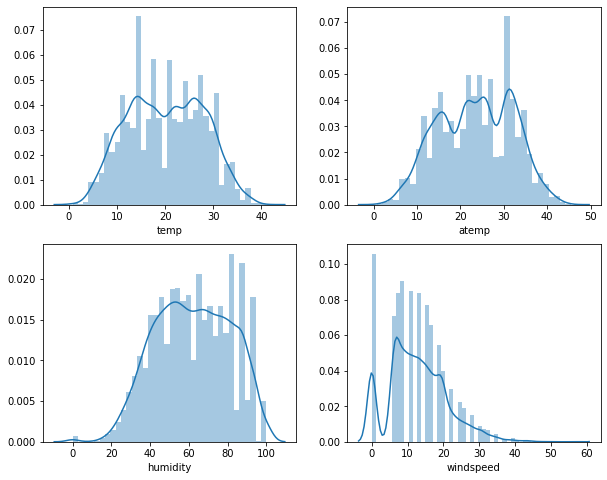

In [17]:
# 스케일링 전 연속형 변수 분포
fig, axs = plt.subplots(2,2, figsize = (10,8))
ax1, ax2, ax3, ax4 = axs.flatten()

sns.distplot(train['temp'], ax = ax1)
sns.distplot(train['atemp'], ax = ax2)
sns.distplot(train['humidity'], ax = ax3)
sns.distplot(train['windspeed'], ax = ax4)

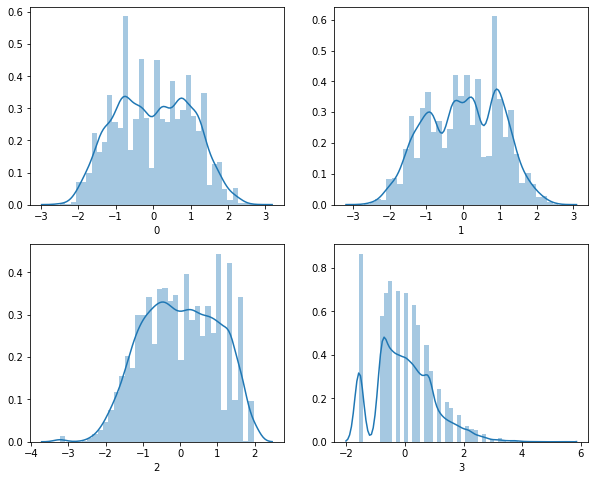

In [18]:
# 예를 들어 StandardScaler를 사용한다면
train_cons = train[['temp', 'atemp', 'humidity', 'windspeed']]

from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
t_scaled = ss.fit_transform(train_cons) #array형태
t_scaled = pd.DataFrame(t_scaled)

# 스케일링 후 연속형 변수 분포: 분포 자체는 별 차이가 없지만 x축을 보면 데이터 자체의 범위가 달라짐 
fig, axs = plt.subplots(2,2, figsize = (10,8))
ax1, ax2, ax3, ax4 = axs.flatten()

sns.distplot(t_scaled[0], ax = ax1)
sns.distplot(t_scaled[1], ax = ax2)
sns.distplot(t_scaled[2], ax = ax3)
sns.distplot(t_scaled[3], ax = ax4)

In [19]:
t_scaled

,0,1,2,3
0,-1.323388,-1.081847,0.985064,-1.565124
1,-1.428831,-1.171656,0.933088,-1.565124
2,-1.428831,-1.171656,0.933088,-1.565124
3,-1.323388,-1.081847,0.673213,-1.565124
4,-1.323388,-1.081847,0.673213,-1.565124
...,...,...,...,...
10733,-0.585288,-0.455544,-0.626165,1.617264
10734,-0.690731,-0.723791,-0.262339,0.270837
10735,-0.796174,-0.902819,-0.054439,0.270837
10736,-0.796174,-0.723791,-0.054439,-0.830412


In [20]:
from sklearn.preprocessing import RobustScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(RobustScaler(), lr_reg)
scores = cross_validate(pipe, X_c, y_c, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 0.933


In [21]:
from sklearn.preprocessing import StandardScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(StandardScaler(), lr_reg)
scores = cross_validate(pipe, X_c, y_c, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 0.933


In [22]:
from sklearn.preprocessing import MinMaxScaler

#선형회귀 모델
lr_reg = LinearRegression()
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lr_reg)
scores = cross_validate(pipe, X_c, y_c, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) #디폴트가 음수라 -를 붙여야 제대로 된 결과가 나옴.

MSLE: 0.933


Ridge

In [23]:
#릿지
ridge_reg = Ridge()
pipe = make_pipeline(RobustScaler(), ridge_reg)
scores = cross_validate(ridge_reg, X_c, y_c, cv = 5, scoring='neg_mean_squared_error',return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.933


In [24]:
#릿지에 대해 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', RobustScaler()), ('ridge',Ridge())])
params={'ridge__alpha':[5, 10, 15, 20]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_c, y_c)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

MSLE: 0.924
optimal hyperparameter:  {'ridge__alpha': 20}


In [25]:
#릿지에 대해 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('ridge',Ridge())])
params={'ridge__alpha':[5, 10, 15, 20]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5)
grid_model.fit(X_c, y_c)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

MSLE: 0.920
optimal hyperparameter:  {'ridge__alpha': 20}


MinMax가 좀 더 좋은듯?
#### Random Forest

In [26]:
#rf
np.random.seed(0)
rf =  RandomForestRegressor(n_estimators=500)
#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), rf)
scores = cross_validate(pipe, X_c, y_c, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.364


In [27]:
#rf 하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('rf',RandomForestRegressor())])
params={'rf__max_depth': [5,10,None],
       'rf__min_samples_leaf': [1,3],
       'rf__min_samples_split': [2, 3],
        'rf__n_estimators': [500, 1000]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_c, y_c)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed: 18.5min finished


MSLE: 0.358
optimal hyperparameter:  {'rf__max_depth': None, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 3, 'rf__n_estimators': 1000}


#### Tree model

In [28]:
#LGBM
lgbm = LGBMRegressor(n_estimators = 500, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_c, y_c, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.332


In [29]:
### 파라미터 튜닝 ###
lgbm = LGBMRegressor(n_estimators = 1000, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_c, y_c, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.350


In [30]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression'))])
params={'lgbm__learning_rate': [0.001, 0.01, 0.1],
       'lgbm__max_depth': [5, 10],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__subsample': [0.5, 1],
       'lgbm__n_estimators': [500, 1000]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_c, y_c)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   28.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  2.5min finished


MSLE: 0.306
optimal hyperparameter:  {'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 1000, 'lgbm__reg_lambda': 0.1, 'lgbm__subsample': 0.5}


In [57]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression', learning_rate = 0.01, subsample = 0.5))])
params={'lgbm__max_depth': [10, 15],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__n_estimators': [500, 1000]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_c, y_c)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:   30.3s finished


MSLE: 0.306
optimal hyperparameter:  {'lgbm__max_depth': 15, 'lgbm__n_estimators': 500, 'lgbm__reg_lambda': 0.1}


### 3-2. registered에 대해 예측 모델

In [23]:
# 1) X, y 나누기
X_r = train_re.drop(['registered'], axis = 1) 
y_r = train_re['registered']

#### lgbm

In [33]:
#LGBM
lgbm = LGBMRegressor(n_estimators = 500, objective = 'regression')

#피처에 대해 표준화 진행과 k-fold를 함께 함
pipe = make_pipeline(MinMaxScaler(), lgbm)
scores = cross_validate(pipe, X_r, y_r, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
print("MSLE: {0:.3f}".format(np.mean(-scores['test_score']))) 

MSLE: 0.182


`casual` 예측모델 train MSLE가 0.3이었던 것에 비해, `registered` 예측모델은 튜닝도 안했는데 0.182가 나왔다.  
좀 더 튜닝해보자

In [34]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression'))])
params={'lgbm__learning_rate': [0.001, 0.01, 0.1],
       'lgbm__max_depth': [5, 10],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__subsample': [0.5, 1],
       'lgbm__n_estimators': [500, 1000]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_r, y_r)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   25.9s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  2.5min finished


MSLE: 0.173
optimal hyperparameter:  {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 500, 'lgbm__reg_lambda': 1, 'lgbm__subsample': 0.5}


In [35]:
#하이퍼 파라미터 튜닝
pipeline = Pipeline([('scaler', MinMaxScaler()), ('lgbm',LGBMRegressor(objective='regression', learning_rate = 0.1, subsample = 0.5))])
params={'lgbm__max_depth': [3, 5, 7],
       'lgbm__reg_lambda':[0.1, 1],
       'lgbm__n_estimators': [300, 500]}
grid_model = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs = 5, verbose=True)
grid_model.fit(X_r, y_r)
print("MSLE: {0:.3f}".format( -1*grid_model.best_score_)) 
print('optimal hyperparameter: ', grid_model.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   14.3s finished


MSLE: 0.168
optimal hyperparameter:  {'lgbm__max_depth': 3, 'lgbm__n_estimators': 500, 'lgbm__reg_lambda': 0.1}


## 4. Predict Test data
만들어진 모델을 바탕으로 test data에 대해 예측해보자.

In [24]:
train_c.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,1.386294,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,2.197225,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,1.791759,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,1.386294,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0.000000,2011,1,4,5


In [25]:
train_re.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,registered,year,month,hour,dayofweek
0,1,0,0,1,9.84,14.395,81,0.0,2.639057,2011,1,0,5
1,1,0,0,1,9.02,13.635,80,0.0,3.496508,2011,1,1,5
2,1,0,0,1,9.02,13.635,80,0.0,3.332205,2011,1,2,5
3,1,0,0,1,9.84,14.395,75,0.0,2.397895,2011,1,3,5
4,1,0,0,1,9.84,14.395,75,0.0,0.693147,2011,1,4,5


In [26]:
# test data를 train_c, train_re처럼 가공
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [27]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek

#datetime 삭제
del test['datetime']

test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3


In [28]:
#카테고리 변수 생성
cate_name = ['weather', 'season', 'year', 'month', 'hour', 'dayofweek']

for c in cate_name:
    test[c] = test[c].astype('category')
test.dtypes

season        category
holiday          int64
workingday       int64
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
month         category
hour          category
dayofweek     category
dtype: object

### 4-1) casual 예측하기
- 사용 모델: `LGBM`

In [29]:
# 피처 표준화
minmax = MinMaxScaler()
minmax.fit(X_c) #훈련셋 모수 분포 저장
X_c_scaled = minmax.transform(X_c)
X_test_scaled = minmax.transform(test)

In [30]:
# 최종 파라미터 튜닝된 모델로 학습 
lgbm1 = LGBMRegressor(n_estimators = 500, objective = 'regression',
                    learning_rate = 0.01, subsample = 0.5, max_depth = 15, reg_lambda = 0.1, ranodm_state = 99)

# 학습
lgbm1.fit(X_c_scaled, y_c)

[LightGBM] [Warning] Unknown parameter: ranodm_state


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=15,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, ranodm_state=99,
              reg_alpha=0.0, reg_lambda=0.1, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

In [31]:
# test에 대해 예측
pred_c = lgbm1.predict(X_test_scaled)
fpred_c = np.expm1(pred_c) #로그변환 값을 풀어줌

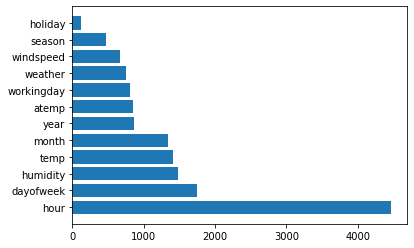

In [32]:
#lgbm1 모델의 feature importance
imp_casual = pd.DataFrame({'feature': test.columns, 
                                    'coefficient': lgbm1.feature_importances_})
imp_casual = imp_casual.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp_casual['feature'], imp_casual['coefficient'])
plt.show()

In [33]:
imp_casual

,feature,coefficient
10,hour,4465
11,dayofweek,1747
6,humidity,1487
4,temp,1413
9,month,1338
8,year,870
5,atemp,851
2,workingday,805
3,weather,760
7,windspeed,669


### 4-2) registered 예측하기
- 사용 모델 : `LGBM`

In [34]:
# 피처 표준화
minmax = MinMaxScaler()
minmax.fit(X_r) #훈련셋 모수 분포 저장
X_r_scaled = minmax.transform(X_r)
X_test_scaled = minmax.transform(test)

In [35]:
# 최종 파라미터 튜닝된 모델로 학습 
lgbm2 = LGBMRegressor(n_estimators = 500, objective = 'regression',
                    learning_rate = 0.1, max_depth = 3, reg_lambda = 0.1, subsample = 0.5,
                     random_state = 99)
# 학습
lgbm2.fit(X_r_scaled, y_r)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=99, reg_alpha=0.0,
              reg_lambda=0.1, silent=True, subsample=0.5,
              subsample_for_bin=200000, subsample_freq=0)

In [36]:
# test에 대해 예측
pred_re = lgbm2.predict(X_test_scaled)
fpred_re = np.expm1(pred_re) #로그변환 값을 풀어줌

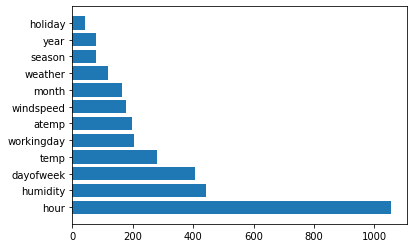

In [37]:
#lgbm2 모델의 feature importance
imp_re = pd.DataFrame({'feature': test.columns, 
                                    'coefficient': lgbm2.feature_importances_})
imp_re = imp_re.sort_values(by = 'coefficient', ascending = False)

plt.barh(imp_re['feature'], imp_re['coefficient'])
plt.show()

In [38]:
imp_re

,feature,coefficient
10,hour,1055
6,humidity,443
11,dayofweek,406
4,temp,281
2,workingday,206
5,atemp,199
7,windspeed,177
9,month,166
3,weather,120
0,season,80


### 4-3) 예측 결과 합산 

In [39]:
test['casual_pred'] = fpred_c
test['re_pred'] = fpred_re
test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek,casual_pred,re_pred
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3,0.705332,7.127777
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3,0.515598,3.410406
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3,0.477733,2.221749


In [40]:
# 합산
test['count'] = test['casual_pred'] + test['re_pred']
test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek,casual_pred,re_pred,count
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3,0.705332,7.127777,7.833109
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3,0.515598,3.410406,3.926004
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3,0.477733,2.221749,2.699482
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3,0.351658,1.277157,1.628816
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3,0.351658,1.172460,1.524119


In [41]:
# submission 가져오기 
sub = pd.read_csv('data/sampleSubmission.csv')
sub.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [42]:
del sub['count']

In [43]:
sub['count'] = test['count']
sub.head()

,datetime,count
0,2011-01-20 00:00:00,7.833109
1,2011-01-20 01:00:00,3.926004
2,2011-01-20 02:00:00,2.699482
3,2011-01-20 03:00:00,1.628816
4,2011-01-20 04:00:00,1.524119


In [44]:
sub.to_csv('Submission_sy_0.csv', index=False)

#### 최종 제출 Score: `0.40720`